In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL
import h5py
import math
import scipy
import torch
import pdb

In [2]:
os.sys.path

['',
 '/home/ubuntu/src/cntk/bindings/python',
 '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python36.zip',
 '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6',
 '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/lib-dynload',
 '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages',
 '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/extensions',
 '/home/ubuntu/.ipython']

In [3]:
home = os.path.expanduser("~")
dataRoot = os.path.join(home, "CS230", "CheXpert-v1.0-small")
os.listdir(dataRoot)

['valid',
 'valid_final.csv',
 'train_final.csv',
 'train_final_V2.csv',
 'train_1_example.csv',
 'train',
 'valid.csv',
 'test_final.csv',
 'train.csv',
 'valid_1_example.csv']

In [4]:
"""Import and Preprocess Data"""

'Import and Preprocess Data'

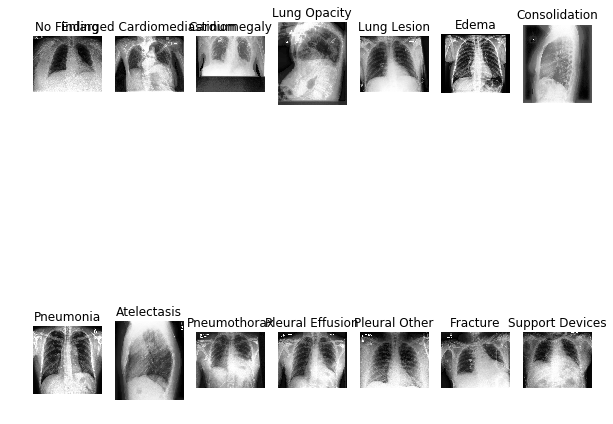

In [5]:
import cv2

TASKS = ['No Finding', 'Enlarged Cardiomediastinum', 
         'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 
         'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
        'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
        'Fracture', 'Support Devices']

def view_dataset(paths, labels, method='cv2'):
    fig, axs = plt.subplots(2, 7, figsize=(10, 10))
    flatted_axs = [item for one_ax in axs for item in one_ax]
    for ax, path, label in zip(flatted_axs, paths[:14], labels[:14]):
        if method == 'cv2':
            img = cv2.imread('/home/ubuntu/CS230/' + path, 3)
        elif method == 'tf':
            img = try_tf_image(path)
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    plt.show() 

from torch.nn import functional as F

def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

df = pd.read_csv('/home/ubuntu/CS230/CheXpert-v1.0-small/train_final_V2.csv')
paths = df['Path'][:14]
labels = df[TASKS][:14]

view_dataset(paths, labels)

In [6]:
from torch.utils.data import Dataset, DataLoader

class Dataset(Dataset):
    def __init__(self, data_split, toy=False):
     
        df = pd.read_csv(data_split)
        
        # Remove any paths for which the image files do not exist
        #df = df[df["Path"].apply(os.path.exists)]
      
        #print ("%s size %d" % (data_split, df.shape[0]))

        #Could remove
        if toy:
            df = df.sample(frac=0.05)

        self.img_paths = df["Path"].apply(lambda x: '/home/ubuntu/CS230/' + x)
        self.labels = df[TASKS]
        self.n_classes = len(self.labels)

    def __getitem__(self, index):
        img = np.array(Image.open(self.img_paths.iloc[index])).astype(np.float32) / 255.
        img = crop_center(img,224,224)
        img = img[np.newaxis,:]
        label = self.labels.iloc[index]
        label = np.nan_to_num(label)
        label[label < 0] = 0
        label_vec = torch.FloatTensor(label).cuda()
        return img, label_vec
          

    def __len__(self):
        return len(self.img_paths)

In [7]:
train_dataset = Dataset('/home/ubuntu/CS230/CheXpert-v1.0-small/train_final_V2.csv',toy=False)
test_dataset = Dataset('/home/ubuntu/CS230/CheXpert-v1.0-small/valid_final.csv',toy=False)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                         shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64,
                                         shuffle=False)

print(len(train_loader))
print(len(test_loader))

782
5


In [8]:
#Define Model

In [9]:
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(28 * 28 * 128, 64)
        self.fc2 = nn.Linear(64, 14)
    #Forward Prop
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [10]:
import torch.optim as optim

model = ConvNet().cuda()
# Define the cost function
criterion = nn.BCEWithLogitsLoss().cuda()

# Define the optimizer, learning rate 
lr = 0.00001
optimizer = optim.Adam(model.parameters(), lr)

In [11]:
def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:0, Iteration: 0, training cost = 0.6968324184417725, Recall score =0.3787878787878788, F1 score =0.17123287671232876


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch:0, Iteration: 100, training cost = 0.35912930965423584, Recall score =0.0, F1 score =0.0
Epoch:0, Iteration: 200, training cost = 0.3982045352458954, Recall score =0.09883720930232558, F1 score =0.16915422885572137
Epoch:0, Iteration: 300, training cost = 0.3701745569705963, Recall score =0.2302158273381295, F1 score =0.326530612244898
Epoch:0, Iteration: 400, training cost = 0.32068920135498047, Recall score =0.3404255319148936, F1 score =0.44239631336405527
Epoch:0, Iteration: 500, training cost = 0.32933732867240906, Recall score =0.2620689655172414, F1 score =0.36714975845410636
Epoch:0, Iteration: 600, training cost = 0.34407904744148254, Recall score =0.25, F1 score =0.33497536945812806
Epoch:0, Iteration: 700, training cost = 0.35772958397865295, Recall score =0.18, F1 score =0.2769230769230769
Epoch:1, Iteration: 0, training cost = 0.3474915623664856, Recall score =0.22666666666666666, F1 score =0.3253588516746411
Epoch:1, Iteration: 100, training cost = 0.314565420150756

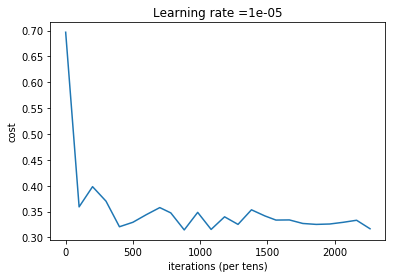

Average recall =0.26205895823250924
Average recall =0.26205895823250924


In [37]:

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

#Train Network
total_step = len(train_loader)
epoch_list = []
loss_list = []
acc_list = []
total_recall = []
f1_total = []

for epoch in range(3):
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs = inputs.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward propogation
        outputs = model(inputs)
        outputs = outputs.cuda()
        
        # calculate the loss
        loss = criterion(outputs, labels)
        
        # backpropogation + update parameters
        loss.backward()
        optimizer.step()

        # print statistics
        cost = loss.item()
        torch.save(model, 'pytorch' + str(epoch))
        outputs = torch.sigmoid(outputs).cpu().detach().numpy()
        outputs[outputs >= 0.5] = 1
        outputs[outputs < 0.5] = 0
        labels = labels.cpu().detach().numpy() 
        
        torch.save(model.state_dict(), '/home/ubuntu/CS230/CS230-Project/Model/result_CustomNet.pt')

        
        recall = recall_score(labels,outputs, average = 'micro')
        total_recall.append(recall)
        
        f1 = f1_score(labels,outputs, average = 'micro')
        f1_total.append(f1)

        if i % 100 == 0:    # print every 1000 iterations
            print('Epoch:' + str(epoch) + ", Iteration: " + str(i) 
                  + ", training cost = " + str(cost) + ", Recall score =" + str(recall) 
                  + ", F1 score =" + str(f1))
            loss_list.append(cost)
            epoch_list.append(epoch*782 + i)

plt.plot(epoch_list,loss_list)
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(lr))
plt.show()

print("Average recall =" + str(sum(total_recall)/len(total_recall)))
print("Average F1 score is: ",sum(f1_total)/len(f1_total))

In [1]:
print("Average F1 score is: ",sum(f1_total)/len(f1_total))

NameError: name 'f1_total' is not defined

In [22]:
#Evaluate Network

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet()
model.load_state_dict(torch.load('/home/ubuntu/CS230/CS230-Project/Model/result_CustomNet.pt'))
model.eval()


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=100352, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=14, bias=True)
)

In [50]:

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from torch.autograd import Variable

def test():
    model = ConvNet().cuda()
    model.load_state_dict(torch.load('/home/ubuntu/CS230/CS230-Project/Model/result_CustomNet.pt'))
    test_recall = []
    f1_test = []
    model.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader):

        
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())

        # Predict classes using images from the test set
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        
        outputs = torch.sigmoid(outputs).cpu().detach().numpy()
        outputs[outputs >= 0.5] = 1
        outputs[outputs < 0.5] = 0
        labels = labels.cpu().detach().numpy()
        
        #test_acc += torch.sum(prediction == labels.data)
        
        recall = recall_score(labels,outputs, average = 'micro')
        test_recall.append(recall)
        
        f1 = f1_score(labels,outputs, average = 'micro')
        f1_test.append(f1)

    # Compute the average acc and loss over all 10000 test images
    #test_acc = test_acc / 10000
    
    print("Average recall =" + str(sum(test_recall)/len(test_recall)))
    print("Average F1 score is: ",sum(f1_test)/len(f1_test))

    return test_acc

In [51]:
test()

Average recall =0.29968247514523505
Average F1 score is:  0.3745161157651127


0.0